In [ ]:
import numpy as np

from prep import TimeWindowTransformer, LabelWindowExtractor

from regressors import NNRegressor
from loss_functions import RMSELoss
from models import ConvNN

from validation import RMSE, NMSE, cross_validate_NN

### Explanation of the new class NNRegressor

The class `NNRegressor` is defined in `regressors.py`. It is essentially a wrapper around a pytorch model that makes it compatible with scikit pipelines. Here is how to use it.

The `__init__` method of an `NNRegressor` instance takes in input:

* `model_class`: a pytorch model class (such as for example `ConvNN` contained in `models.py`);

* `model_parameters`: a dictionary containing the keyword arguments to be passed to `model_class` whenever the model is initialized;

* `loss_fnc`: a dictionary of named loss functions, taking in input numpy arrays and returning numbers; practically, this will always be `{'RMSE': RMSE, 'NMSE': NMSE}` where `RMSE, NMSE` are imported from `validation.py`

* `batch_size`, `learning_rate`, `max_epochs`, `patience`: these are pretty self-explanatory hyperparameters that are used to train the model.

Any instance of `NNRegressor` has three methods:
* `.fit`: takes in input a pair `(X,y)` of NUMPY arrays. The shape depends on the particular model class we are using, but we DO NOT pass the data split into sessions.

For example, in the case of `ConvNN` which works directly with time windows, `X` will have shape `(N, 8, 500)`, while `y` will have shape `(N, 51)`. `.fit` returns the `self` instance of `NNRegressor` (NOT the pytorch model!).

The "best" weights and biases of the neural network are internally saved in the attribute `.best_model` of the `NNRegressor` instance. In this case, "best" means that I take the weights and biases with lowest TRAINING loss function (that's the only way I could think of to avoid leakage).

The `patience` hyperparameter sets a possible early exit: if at training time the training loss is not improved in `patience` epochs, the training loop ends early.

* `.predict`: takes in input a NUMPY array `X` of the same shape of the `X` taken in input by `.fit`, and returns the predicted values of the model which uses the best weights and biases obtained at training time (for this reason, calling `.predict` before calling `.fit` or `.fit_with_validation` will throw an exception because `.best_model` is initialized to `None`).

* `.fit_with_validation`: this is a custom method which is not used by scikit pipelines, but is useful for us for architecture selection and hyperparameter tuning. This guy takes in input `(X_train, y_train, X_val, y_val)` which are NUMPY arrays of shape respectively `(N_train, ...), (N_train, 51), (N_val, ...), (N_val, 51)`.

This methods trains exactly the same model obtained by calling `.fit(X_train, y_train)`; however, it also computes and prints the average batch validation loss on the unseen data `(X_val, y_val)`.

Finally, this method returns a tuple `(train_losses, val_losses)` of numpy array of length equal to the number of epochs (which cannot exceed `max_epochs`, but can be smaller if the training loop exits earlier because of the patience mechanism).

### Explanation of the validation function cross_validate_NN

This function is in `validation.py` and it works similarly to `cross_validate_pipeline`. It takes in input an instance of `NNRegressor`, and the parameters `X_folds`, `Y_folds`, `metric_fns`, `n_folds`, `verbose` exactly as `cross_validate_pipeline`. So, in this case, `X_folds` and `Y_folds` are split into sessions.

For example, if the model we used to initialize our `NNRegressor` is `ConvNN`, the input of the `.fit` method should be a pair `X,y` with shape `(N, 8, 500)` and `(N, 51)` respectively. Therefore, the parameters `X_folds` and `Y_folds` of `cross_validate_NN` sholuld have shape `(n_folds, M, 8, 500)` and `(n_folds, M, 51)` respectively. `n_folds` is set to 4 by default, but it should be equal to the first dimension of `X_folds` and `Y_folds`.

The parameter `verbose` can take values 0,1,2,3. If we set it to 0,1,2 it does exactly the same that `cross_validate_pipeline` does. If we set it to `3`, the instance of `NNRegressor` calls `.fit_with_validation` rather than `.fit`, and therefore all the validation results are printed out, included the graphs showing the learning curves per fold.

This is easier to use than to explain!

### Loading, windowing

In [12]:
PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'freemoves' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

tw_extractor = TimeWindowTransformer(size = 500, step = 100)
label_extractor = LabelWindowExtractor(size = 500, step = 100)

X_windows = tw_extractor.transform(X)
Y_labels = label_extractor.transform(Y)

train_val_idx = [0,1,2,3]
test_idx = 4

X_train_val_folds = X_windows[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

X_test = X_windows[test_idx]
Y_test = Y_labels[test_idx]

### Testing Marco's model

FOLD 1/4
Epoch 001 | Train Loss: 25.3426 | Val Loss: 20.9995 | 
Epoch 002 | Train Loss: 19.3591 | Val Loss: 14.0318 | 
Epoch 003 | Train Loss: 13.4840 | Val Loss: 11.1316 | 
Epoch 004 | Train Loss: 10.9027 | Val Loss: 12.8235 | 
Epoch 005 | Train Loss: 10.0992 | Val Loss: 10.4888 | 
Epoch 006 | Train Loss: 9.6237 | Val Loss: 10.0749 | 
Epoch 007 | Train Loss: 9.4670 | Val Loss: 10.4062 | 
Epoch 008 | Train Loss: 9.3533 | Val Loss: 9.9289 | 
Epoch 009 | Train Loss: 9.1486 | Val Loss: 10.5895 | 
Epoch 010 | Train Loss: 9.1490 | Val Loss: 9.9480 | 
Epoch 011 | Train Loss: 9.0279 | Val Loss: 10.7595 | 
Epoch 012 | Train Loss: 8.8727 | Val Loss: 10.9683 | 
Epoch 013 | Train Loss: 8.7927 | Val Loss: 9.7738 | 
Epoch 014 | Train Loss: 8.8428 | Val Loss: 9.7571 | 
Epoch 015 | Train Loss: 8.6698 | Val Loss: 10.2045 | 
Epoch 016 | Train Loss: 8.6012 | Val Loss: 10.1828 | 
Epoch 017 | Train Loss: 8.6210 | Val Loss: 11.0303 | 
Epoch 018 | Train Loss: 8.5322 | Val Loss: 11.2800 | 
Epoch 019 | Train 

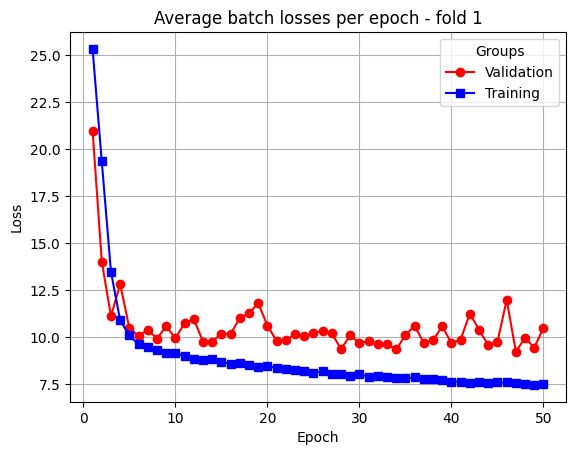

FOLD 2/4
Epoch 001 | Train Loss: 22.8789 | Val Loss: 25.0473 | 
Epoch 002 | Train Loss: 17.4182 | Val Loss: 19.5796 | 
Epoch 003 | Train Loss: 12.4226 | Val Loss: 14.6653 | 
Epoch 004 | Train Loss: 10.0520 | Val Loss: 14.4432 | 
Epoch 005 | Train Loss: 9.2773 | Val Loss: 14.1487 | 
Epoch 006 | Train Loss: 8.9084 | Val Loss: 15.8153 | 
Epoch 007 | Train Loss: 8.7249 | Val Loss: 14.4464 | 
Epoch 008 | Train Loss: 8.5534 | Val Loss: 14.5072 | 
Epoch 009 | Train Loss: 8.4010 | Val Loss: 14.3662 | 
Epoch 010 | Train Loss: 8.2969 | Val Loss: 12.6480 | 
Epoch 011 | Train Loss: 8.1673 | Val Loss: 12.9825 | 
Epoch 012 | Train Loss: 8.1091 | Val Loss: 13.0894 | 
Epoch 013 | Train Loss: 8.0779 | Val Loss: 13.9217 | 
Epoch 014 | Train Loss: 7.9843 | Val Loss: 14.8451 | 
Epoch 015 | Train Loss: 7.8454 | Val Loss: 14.3583 | 
Epoch 016 | Train Loss: 7.7910 | Val Loss: 13.9082 | 
Epoch 017 | Train Loss: 7.8431 | Val Loss: 13.8156 | 
Epoch 018 | Train Loss: 7.7862 | Val Loss: 13.8002 | 
Epoch 019 | Tra

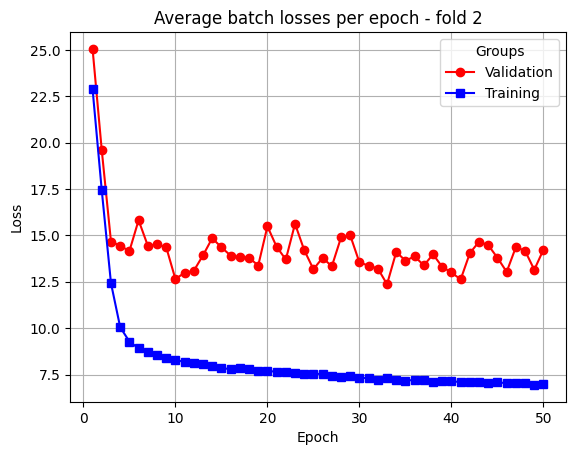

FOLD 3/4
Epoch 001 | Train Loss: 24.8388 | Val Loss: 21.0798 | 
Epoch 002 | Train Loss: 19.0076 | Val Loss: 16.3259 | 
Epoch 003 | Train Loss: 13.3725 | Val Loss: 12.4353 | 
Epoch 004 | Train Loss: 10.7536 | Val Loss: 11.0187 | 
Epoch 005 | Train Loss: 9.9716 | Val Loss: 11.0119 | 
Epoch 006 | Train Loss: 9.5796 | Val Loss: 10.6315 | 
Epoch 007 | Train Loss: 9.2853 | Val Loss: 10.5359 | 
Epoch 008 | Train Loss: 9.1278 | Val Loss: 10.3798 | 
Epoch 009 | Train Loss: 9.0480 | Val Loss: 10.6258 | 
Epoch 010 | Train Loss: 8.9484 | Val Loss: 10.6307 | 
Epoch 011 | Train Loss: 8.9002 | Val Loss: 10.3566 | 
Epoch 012 | Train Loss: 8.7859 | Val Loss: 10.7204 | 
Epoch 013 | Train Loss: 8.6854 | Val Loss: 10.3778 | 
Epoch 014 | Train Loss: 8.6099 | Val Loss: 10.1534 | 
Epoch 015 | Train Loss: 8.5146 | Val Loss: 10.3412 | 
Epoch 016 | Train Loss: 8.5068 | Val Loss: 10.4948 | 
Epoch 017 | Train Loss: 8.3725 | Val Loss: 10.3021 | 
Epoch 018 | Train Loss: 8.3401 | Val Loss: 10.4493 | 
Epoch 019 | Tra

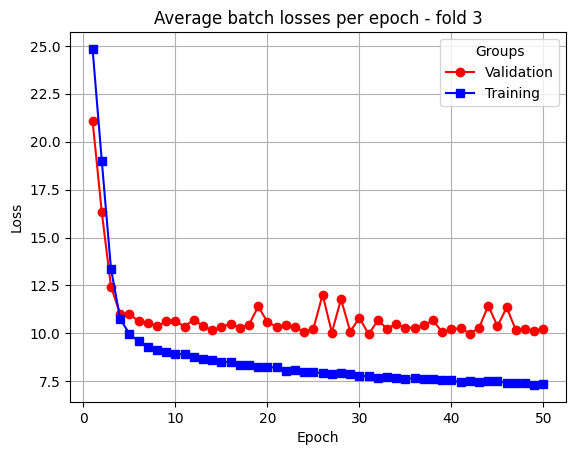

FOLD 4/4
Epoch 001 | Train Loss: 25.6366 | Val Loss: 18.7063 | 
Epoch 002 | Train Loss: 19.7820 | Val Loss: 13.3846 | 
Epoch 003 | Train Loss: 13.9923 | Val Loss: 11.6385 | 
Epoch 004 | Train Loss: 11.0778 | Val Loss: 10.1882 | 
Epoch 005 | Train Loss: 10.2019 | Val Loss: 9.7749 | 
Epoch 006 | Train Loss: 9.8166 | Val Loss: 9.1106 | 
Epoch 007 | Train Loss: 9.5325 | Val Loss: 10.5526 | 
Epoch 008 | Train Loss: 9.4361 | Val Loss: 8.8627 | 
Epoch 009 | Train Loss: 9.2799 | Val Loss: 8.6522 | 
Epoch 010 | Train Loss: 9.2663 | Val Loss: 8.6479 | 
Epoch 011 | Train Loss: 9.0794 | Val Loss: 10.1987 | 
Epoch 012 | Train Loss: 8.9223 | Val Loss: 8.6878 | 
Epoch 013 | Train Loss: 8.9768 | Val Loss: 8.5677 | 
Epoch 014 | Train Loss: 8.9364 | Val Loss: 9.7564 | 
Epoch 015 | Train Loss: 8.7557 | Val Loss: 8.8065 | 
Epoch 016 | Train Loss: 8.7040 | Val Loss: 8.8388 | 
Epoch 017 | Train Loss: 8.7224 | Val Loss: 8.4372 | 
Epoch 018 | Train Loss: 8.6120 | Val Loss: 8.4791 | 
Epoch 019 | Train Loss: 8.

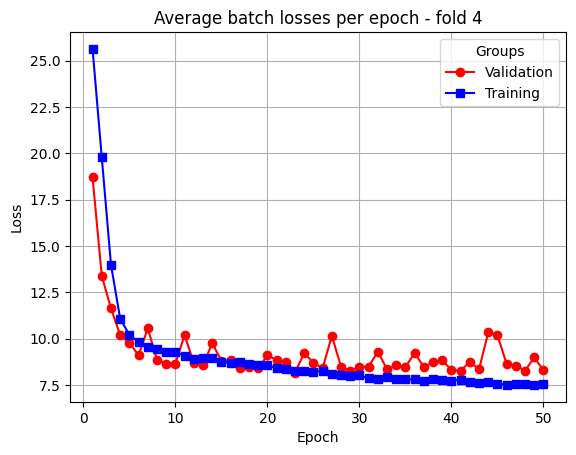


Average Scores across folds:
RMSE: train=6.9428, val=12.3503
NMSE: train=0.2933, val=1.0353


In [13]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

results = cross_validate_NN(
    my_NNRegressor,
    X_train_val_folds,
    Y_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

In [15]:
# test on unseen data

# initialize the model
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

# train on the first four sessions
X_train = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

my_NNRegressor.fit(X_train, Y_train)

# compute the prediction of the fifth session
Y_test_pred = my_NNRegressor.predict(X_test)

# compute the errors
print(RMSE(Y_test_pred, Y_test))
print(NMSE(Y_test_pred, Y_test))

11.791379650010189
1.2468461510168667
